# William Kiger - Kristopher Gallagher
Spring 2023 DLH 598 Final Project
RAPS Implemented as in https://arxiv.org/abs/2009.14193 
and https://github.com/aangelopoulos/conformal_classification

In [5]:
import os
import sys
import random
import time
import numpy as np
import matplotlib.pyplot as plt 
import collections, itertools, json, os, pathlib, sys


#imports from Conforamal RAPS
from conformal_raps.conformal import *
from conformal_raps.utils import *

#PyTorch imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

In [1]:
# Upload the model file
from google.colab import files
uploaded = files.upload()

Saving conformal_raps.zip to conformal_raps.zip
Saving my_utils.py to my_utils.py
Saving my_conformal.py to my_conformal.py
Saving validation_dataset.zip to validation_dataset.zip
Saving resnet_18_derm_model_test_v2.pt to resnet_18_derm_model_test_v2.pt


# Setting up our transforms for infernece

In [3]:
zip_file = 'conformal_raps.zip'

# Extract the contents of the ZIP file
import zipfile
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
#setting seeds to 0 for reproducability
np.random.seed(seed=0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
random.seed(0)

# Normalization from torchvision repo
transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std= [0.229, 0.224, 0.225])
            ])

In [7]:
cudnn.benchmark = True
batch_size = 128
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device = " + str(device))

Device = cuda:0


# Load our model

In [8]:
model_path = r"resnet_18_derm_model_test_v2.pt"
model = torch.load(model_path)
# model.to(device)
model = torch.nn.DataParallel(model)  # wdk...for multi-gpu instances
#model to eval mode
_ = model.eval()

# Get the conformal calibration and validation datasets

In [9]:
root = r'validation_dataset'
validate_path = os.path.join(root, 'val')

calibration_dataset, validation_dataset = torch.utils.data.random_split(
    torchvision.datasets.ImageFolder(validate_path, transform), [100, 890-100]) #[num, num_image-num]

calib_loader = torch.utils.data.DataLoader(
    calibration_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Conformalize the model - perform platt scaling and then wrap the model with RAPS

In [10]:
cmodel = ConformalModel(model, calib_loader, alpha=0.1, lamda_criterion='size')

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:07<00:00,  7.96s/it]

Optimal T=1.299961805343628


# Validate the coverage of the conformal model and validation sets.  Note that the running averages of coverage and size are in parenthesis.  

In [11]:
top1, top5, coverage, size = validate(val_loader, cmodel, print_bool=True)

N: 790 | Time: 0.418 (1.442) | Cvg@1: 0.636 (0.415) | Cvg@5: 0.955 (0.857) | Cvg@RAPS: 0.955 (0.889) | Size@RAPS: 5.545 (5.322)


# Now use RAPS 

In [12]:
#prefilling parameters
num_images = 890
num_calib = 100

class_names = {0: 'allergic_contact_dermatitis', 1: 'basal_cell_carcinoma', 2: 'folliculitis', 
               3: 'lichen_planus', 4: 'lupus_erythematosus', 5: 'neutrophilic_dermatoses', 
               6: 'photodermatoses', 7: 'psoriasis', 8: 'sarcoidosis', 9: 'squamous_cell_carcinoma'}
class_names = list(class_names.values())

Image 0 has label 'allergic_contact_dermatitis', and the predictive set is ['lichen_planus', 'psoriasis', 'photodermatoses', 'sarcoidosis', 'squamous_cell_carcinoma', 'allergic_contact_dermatitis'].
Image 1 has label 'basal_cell_carcinoma', and the predictive set is ['squamous_cell_carcinoma', 'lichen_planus', 'basal_cell_carcinoma', 'allergic_contact_dermatitis', 'lupus_erythematosus', 'psoriasis'].
Image 2 has label 'folliculitis', and the predictive set is ['sarcoidosis', 'psoriasis', 'allergic_contact_dermatitis', 'photodermatoses', 'lichen_planus', 'lupus_erythematosus'].
Image 3 has label 'lichen_planus', and the predictive set is ['folliculitis', 'allergic_contact_dermatitis', 'psoriasis', 'squamous_cell_carcinoma', 'basal_cell_carcinoma', 'lichen_planus'].
Image 4 has label 'lupus_erythematosus', and the predictive set is ['psoriasis', 'lichen_planus', 'allergic_contact_dermatitis', 'squamous_cell_carcinoma', 'lupus_erythematosus'].
Image 5 has label 'neutrophilic_dermatoses', 

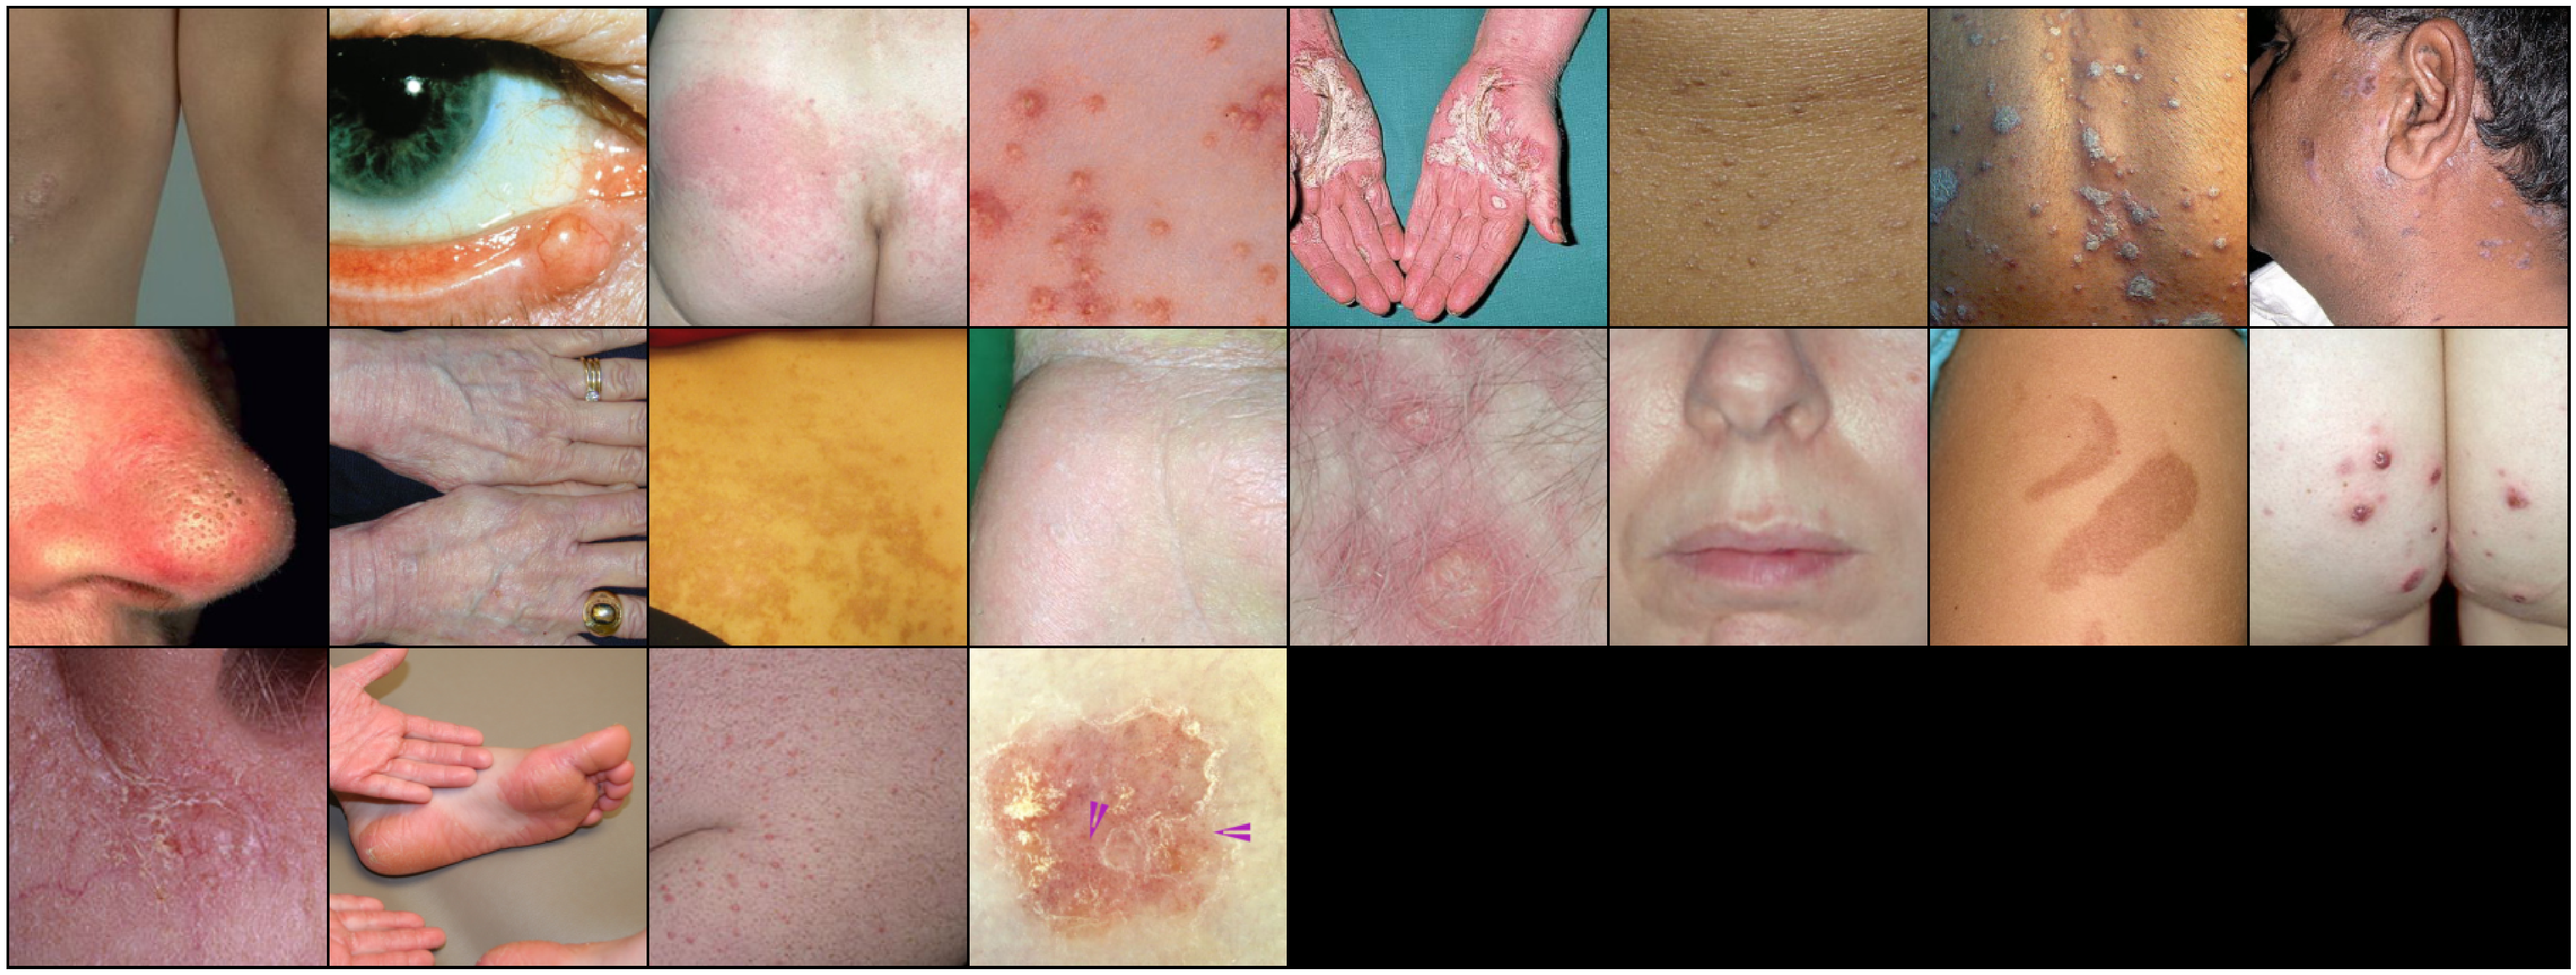

In [13]:
num_images = 20
explore_data, _ = torch.utils.data.random_split(validation_dataset, [num_images, 890-num_calib-num_images])

mosaiclist = []
sets = []
labels = class_names

for data in explore_data:
    img, label = data
    scores, set = cmodel(img.view(1,3,224,224).cuda())
    unnormalized_img = (img * torch.Tensor([0.229, 0.224, 0.225]).view(-1,1,1))+torch.Tensor([0.485, 0.456, 0.406]).view(-1,1,1)
  
    set = [class_names[s] for s in set[0]]
    sets = sets + [set]
    labels = labels + [class_names[label]]
    mosaiclist = mosaiclist + [unnormalized_img]

grid = torchvision.utils.make_grid(mosaiclist)

fig, ax = plt.subplots(figsize=(min(num_images,9)*5, np.floor(num_images/9+1)*5))
ax.imshow(grid.permute(1,2,0), interpolation='nearest')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()

for i in range(len(mosaiclist)):
    print(f"Image {i} has label \'{labels[i]}\', and the predictive set is {sets[i]}.")

# This is showing that our not-so-great model has offered the set of predictions for the medical practicioner to further descriminate the inferences

In [17]:
def get_labels(model, explore_data):
  mosaiclist = []
  sets = []
  labels = class_names

  for data in validation_dataset:
    img, label = data
    scores, set = model(img.view(1,3,224,224).cuda())
    unnormalized_img = (img * torch.Tensor([0.229, 0.224, 0.225]).view(-1,1,1))+torch.Tensor([0.485, 0.456, 0.406]).view(-1,1,1)
  
    set = [class_names[s] for s in set[0]]
    sets = sets + [set]
    labels = labels + [class_names[label]]
    mosaiclist = mosaiclist + [unnormalized_img]

  return mosaiclist, sets, labels


In [18]:
def get_coverage(labels: list, prediction_sets: list) -> float:
    k = len(labels)
    assert k
    correct = 0
    for label, pred in zip(labels, prediction_sets):
        correct += 1 if label in pred else 0
    return correct / k

def get_cardinality(prediction_sets: list) -> float:
    k = len(prediction_sets)
    assert k
    return sum([len(x) for x in prediction_sets]) / k


Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Optimal T=1.299961805343628
Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Optimal T=1.299961805343628
Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Optimal T=1.299961805343628
Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Optimal T=1.299961805343628
Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Optimal T=1.299961805343628


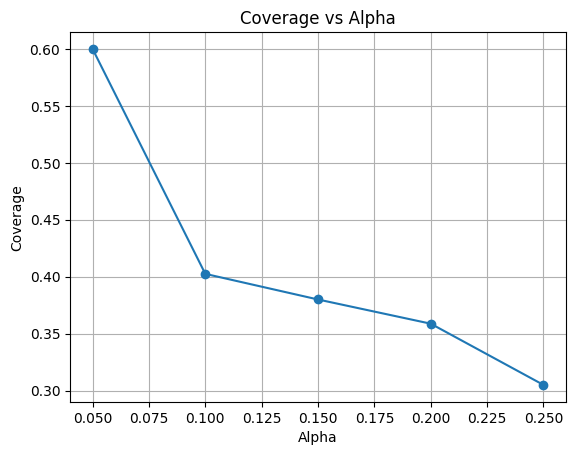

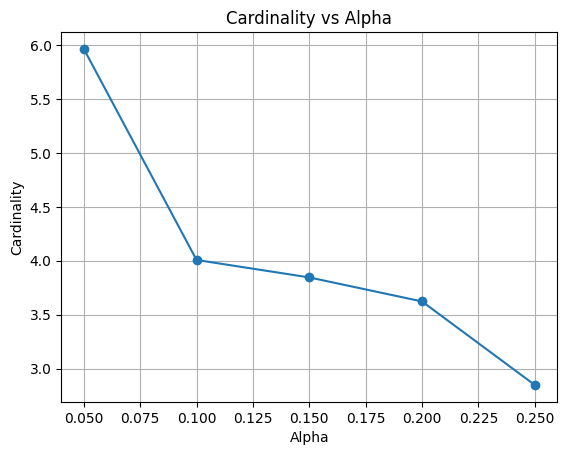

In [19]:
import matplotlib.pyplot as plt

alphas = [0.05, 0.1, 0.15, 0.2, 0.25]
cmodels = []
results = []

for alpha in alphas:
    cmodel = ConformalModel(model, calib_loader, alpha=alpha, lamda_criterion='size')
    cmodels.append(cmodel)
    mosaiclist, sets, labels = get_labels(cmodel, explore_data)
    coverage = get_coverage(labels, sets)
    cardinality = get_cardinality(sets)
    results.append((coverage, cardinality))

# Separate coverage and cardinality values
coverages, cardinalities = zip(*results)

# Plot coverage vs alpha
plt.figure()
plt.plot(alphas, coverages, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Coverage')
plt.title('Coverage vs Alpha')
plt.grid()

# Plot cardinality vs alpha
plt.figure()
plt.plot(alphas, cardinalities, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Cardinality')
plt.title('Cardinality vs Alpha')
plt.grid()

# Display the graphs
plt.show()
